In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


import pickle
from sklearn.esemble import 

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.evalutation import 



In [3]:
def one_hot_encode(df, column, prefix):# found this function which is b
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

def preprocess_data(df, scale=False, one_hot=False , age_groupe = False ):
    
    #drop ID - has only unique values
    df = df.drop('CLIENTNUM', axis=1)
    
    # if True create  Age_groupe
    if age_groupe == True:
        list_AgeGroup = [df]
        for column in list_AgeGroup:
            df.loc[column["Customer_Age"] < 18,  'age_group'] = 18
            df.loc[(column["Customer_Age"] >= 19) & (column["Customer_Age"] <= 29), 'age_group'] = 20
            df.loc[(column["Customer_Age"] >= 30) & (column["Customer_Age"] <= 39), 'age_group'] = 30
            df.loc[(column["Customer_Age"] >= 40) & (column["Customer_Age"] <= 49), 'age_group'] = 40
            df.loc[(column["Customer_Age"] >= 50) & (column["Customer_Age"] <= 59), 'age_group'] = 50
            df.loc[column["Customer_Age"] >= 60, 'age_group'] = 60
        
    
    # handle unknown values
    df['Income_Category'] = df['Income_Category'].replace('Unknown', np.NaN)
   
    
    # Fill ordinal missing values with modes ( Income_Category column)
    df['Income_Category'] = df['Income_Category'].fillna('Less than $40K')
    
    # handle unknown values of marital status
    df['Marital_Status'] = df['Marital_Status'].replace('Unknown', np.NaN)
    
    # Fill missing values with dominant value ( Marital_Status column)
    df['Marital_Status'] = df['Marital_Status'].fillna(df['Marital_Status'].value_counts().index[0])

    #Ordinal Variables Encoding

    Income_Category_map = {
    'Less than $40K' : 0,
    '$40K - $60K'    : 1,
    '$60K - $80K'    : 2,
    '$80K - $120K'   : 3,
    '$120K +'        : 4

    }
    
    
    
    Card_Category_map = {
    'Blue'     : 0,
    'Silver'   : 1,
    'Gold'     : 2,
    'Platinum' : 3
    }


    Attrition_Flag_map = {
    'Existing Customer' : 0,
    'Attrited Customer' : 1
    }

    # Too many Unknown value to exclude it
    Education_Level_map = {
    'Uneducated'    : 0,
    'High School'   : 1,
    'College'       : 2,
    'Graduate'      : 3,
    'Post-Graduate' : 4,
    'Doctorate'     : 5,
    'Unknown'       : 6
    }
    
    Gender_Map = {
        'M' : 0,
        'F' : 1
    }

    df.loc[:, 'Income_Category'] = df['Income_Category'].map(Income_Category_map)
    df.loc[:, 'Attrition_Flag'] = df['Attrition_Flag'].map(Attrition_Flag_map)
    df.loc[:, 'Education_Level'] = df['Education_Level'].map(Education_Level_map)
    df.loc[:, 'Gender'] = df['Gender'].map(Gender_Map)
    
    #encoding using the function above creating + deleting old columns
    if one_hot == True:
        
        df = one_hot_encode(df, 'Marital_Status', prefix='MS')
        df = one_hot_encode(df, 'Card_Category', prefix='CC')
    else:
        df.loc[:, 'Card_Category'] = df['Card_Category'].map(Card_Category_map)
    
    # Label Encoder
    le = LabelEncoder()
    
    # the remaining categorical data are 'objects' as datatyes
    categ = [x for x in df.columns if df[x].dtype == 'object']
    
    #fit_transform on each categorical column
    for a in categ:
        df.loc[:, a]=le.fit_transform(df.loc[:,a])
        
   
    #X["Total_Trans_Ct_Categorical"] = pd.cut(X.Total_Trans_Ct,bins = 16, labels = range(1,17)) 
    #X["Total_Trans_Amt_Categorical"] =pd.cut(X.Total_Trans_Amt,bins = 16, labels = range(1,17))

    
    
    
    y = df.Attrition_Flag 
    X = df.drop('Attrition_Flag', axis=1)
    
   
    
    
    #Scale X
    if scale == True:
        scaler = StandardScaler()
        ro_sc = RobustScaler()

        X_ =X.loc[:,['Customer_Age', 
                     'Dependent_count',
                     'Months_on_book', 
                     'Total_Relationship_Count',
                     'Months_Inactive_12_mon',
                     'Contacts_Count_12_mon',
                     'Credit_Limit',
                     'Total_Revolving_Bal',
                     'Avg_Open_To_Buy',
                     'Total_Amt_Chng_Q4_Q1',
                     'Total_Trans_Amt',
                     'Total_Trans_Ct', 
                     'Total_Ct_Chng_Q4_Q1',
                     'Avg_Utilization_Ratio']]
        
        X = X.drop(['Customer_Age',
                    'Dependent_count',
                    'Months_on_book',
                    'Total_Relationship_Count',
                    'Months_Inactive_12_mon',
                    'Contacts_Count_12_mon',
                    'Credit_Limit',
                    'Total_Revolving_Bal',
                    'Avg_Open_To_Buy', 
                    'Total_Amt_Chng_Q4_Q1',
                    'Total_Trans_Amt',
                    'Total_Trans_Ct', 
                    'Total_Ct_Chng_Q4_Q1',
                    'Avg_Utilization_Ratio'], axis= 1)
    
        X_ = pd.DataFrame(scaler.fit_transform(X_), columns=X_.columns)
        
        X = X.merge(X_, left_index = True, right_index = True)
        
        
        X_2 = X.loc[:,['Credit_Limit', 'Total_Amt_Chng_Q4_Q1','Total_Trans_Amt' ]]
        X = X.drop(['Credit_Limit',  'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt'], axis = 1)
        
        X_2 = pd.DataFrame(ro_sc.fit_transform(X_2), columns= X_2.columns)
        X = X.merge(X_2, left_index = True, right_index = True)
       
    
        #create bins for bimodal continious data
        X["Total_Trans_Ct_Categorical"] = pd.cut(X.Total_Trans_Ct,bins = 16, labels = range(1,17)) 
        X["Total_Trans_Amt_Categorical"] =pd.cut(X.Total_Trans_Amt,bins = 16, labels = range(1,17))

    
    return X, y

In [4]:
data = pd.read_csv('ChurnPrediction/churn-prediction.csv')

In [5]:
X, y = preprocess_data(data, scale=False, one_hot=False) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
grid_search_clf = pickle.load(open('grid_search.sav', 'rb'))

In [18]:
grid_search_clf.best_estimator_

GradientBoostingClassifier(max_depth=5, max_features='log2', n_estimators=300,
                           random_state=0)

In [ ]:
GradientBoostingClassifier(max_depth=5, max_features='log2', n_estimators=300,
                           random_state=0)

In [20]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report


X, y = preprocess_data(data, scale=False, one_hot=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


gb = GradientBoostingClassifier(n_estimators=300, learning_rate = 0.1, max_features='log2', max_depth = 5, random_state = 0)
gb.fit(X_train, y_train)

predictGB= gb.predict(X_test)


print('Gradient Boost Classifier : \n', classification_report(predictGB, y_test))
print('Gradient Boost Classifier Accuracy: ', accuracy_score(predictGB, y_test))

Gradient Boost Classifier : 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1713
           1       0.88      0.92      0.90       313

    accuracy                           0.97      2026
   macro avg       0.93      0.95      0.94      2026
weighted avg       0.97      0.97      0.97      2026

Gradient Boost Classifier Accuracy:  0.9684106614017769


In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print('MAE:', mean_absolute_error(predictGB, y_test) )
print('MSE:', mean_squared_error(predictGB, y_test) )
print('RMSE:', np.sqrt(mean_squared_error(predictGB, y_test) ))

MAE: 0.0315893385982231
MSE: 0.0315893385982231
RMSE: 0.1777338982811751


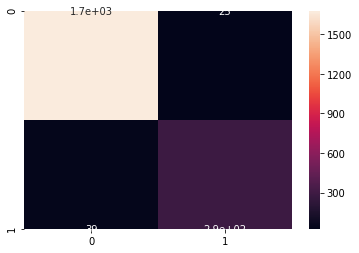

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictGB)
sns.heatmap(cm, annot=True);

In [27]:
import matplotlib 

# get important features
plt.figure(figsize=(15,7))
feature_list = pd.Series(modelGB.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_list.nlargest(10).sort_values(ascending=True).plot(kind='barh')
plt.show()

TypeError: 'module' object is not callable